# Gaussian processes with spectral mixture kernel

In this notebook we will demonstrate how to marginalise over the hyperparameters of a Gaussian process with a spectral mixture kernel. The spectral mixture kernel is a flexible kernel that can model a wide range of functions. The spectral mixture kernel can be read about here: https://gpss.cc/gpss21/slides/Heinonen2021.pdf

In [1]:
# For Gaussian processes 64bit is important
from jax import config

config.update("jax_enable_x64", True)

import tensorflow_probability.substrates.jax as tfp

tfpd = tfp.distributions
tfpk = tfp.math.psd_kernels

from jaxns import marginalise_dynamic, ForcedIdentifiability, maximum_a_posteriori_point, evaluate_map_estimate
from jax.scipy.linalg import solve_triangular
from jax import random
from jax import numpy as jnp
import pylab as plt

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


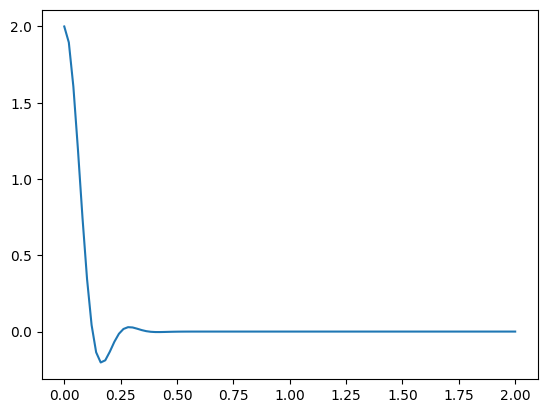

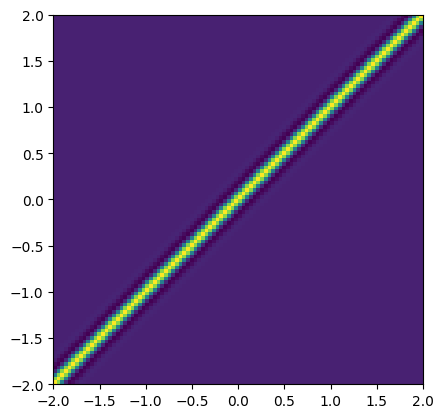

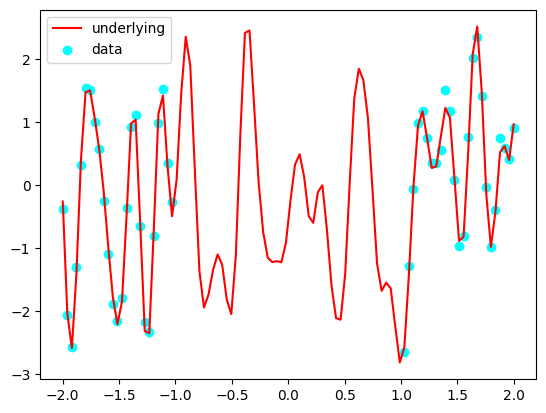

In [2]:
N = 100
Xstar = jnp.linspace(-2., 2., N)[:, None]
mask = jnp.concatenate([jnp.arange(25), jnp.arange(75, N)])
X = Xstar[mask]

true_uncert = 0.1

spectral_params_true = dict(
    logits=jnp.asarray([0., 0.]),
    locs=jnp.asarray([1. / 1, 1. / 0.5]),
    scales=jnp.asarray([1. / 4., 1 / 0.8])
)
prior_cov = tfpk.SpectralMixture(**spectral_params_true).matrix(Xstar, Xstar) + 1e-12 * jnp.eye(N)

v = jnp.linspace(0., 2., 100)
kern = tfpk.SpectralMixture(**spectral_params_true).matrix(jnp.zeros((1, 1)), v[:, None])
plt.plot(v, kern[0, :])
plt.show()

plt.imshow(prior_cov, origin='lower', extent=(Xstar.min(), Xstar.max(), Xstar.min(), Xstar.max()))
plt.show()

Y = jnp.linalg.cholesky(prior_cov) @ random.normal(random.PRNGKey(42), shape=(N,))
Y_obs = Y[mask]
Y_obs += true_uncert * random.normal(random.PRNGKey(1), shape=Y_obs.shape)
# Y = jnp.cos(jnp.pi*2. * X[:,0]/2) + jnp.exp(- X[:,0]/2) * jnp.sin(jnp.pi*2. * X[:,0]/3)


plt.plot(Xstar[:, 0], Y, c='red', label='underlying')
plt.scatter(X[:, 0], Y_obs, c='cyan', label='data')
plt.legend()
plt.show()


-------
Num samples: 105
Num likelihood evals: 848
Efficiency: 0.2203567681007345
log(L) contour: -381.60356122205735
log(Z) est.: -42.98759642417672 +- 0.7705647036568546
log(Z | remaining) est.: 345.4835299983085 +- 1.1304045552760837
ESS: 0.6148782647708803

-------
Num samples: 210
Num likelihood evals: 2350
Efficiency: 0.10752688172043011
log(L) contour: -102.01013904144637
log(Z) est.: -43.455666558296734 +- 0.7593874870072912
log(Z | remaining) est.: 64.22203250325555 +- 0.9233375266739728
ESS: 0.640934529751051

-------
Num samples: 315
Num likelihood evals: 5655
Efficiency: 0.04805491990846682
log(L) contour: -70.01398111898914
log(Z) est.: -43.50028343490676 +- 0.606697970263334
log(Z | remaining) est.: 31.87092717085062 +- 0.6848511529579743
ESS: 1.1296597984979377

-------
Num samples: 420
Num likelihood evals: 10299
Efficiency: 0.030697266481508553
log(L) contour: -55.002448985978695
log(Z) est.: -43.22870425655559 +- 0.4064030835571107
log(Z | remaining) est.: 17.67634009

/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jaxns/plotting.py:45: UserWarning: Found samples with zero likelihood evaluations.
  warnings.warn("Found samples with zero likelihood evaluations.")
/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jaxns/plotting.py:49: RuntimeWarning: divide by zero encountered in divide
  1. / num_likelihood_evaluations_per_sample


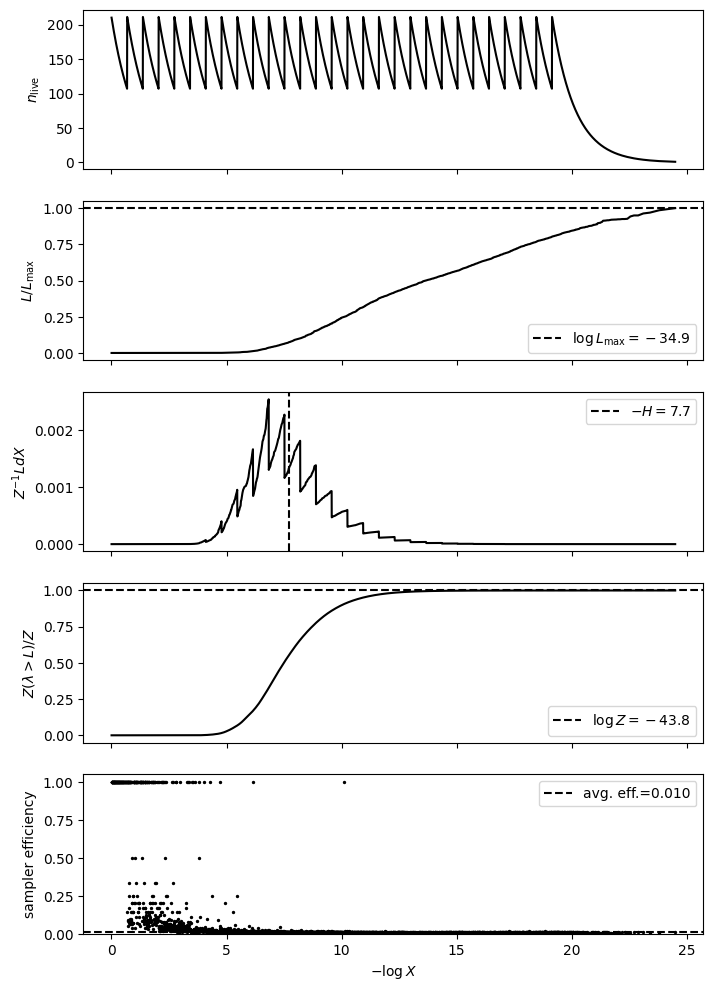

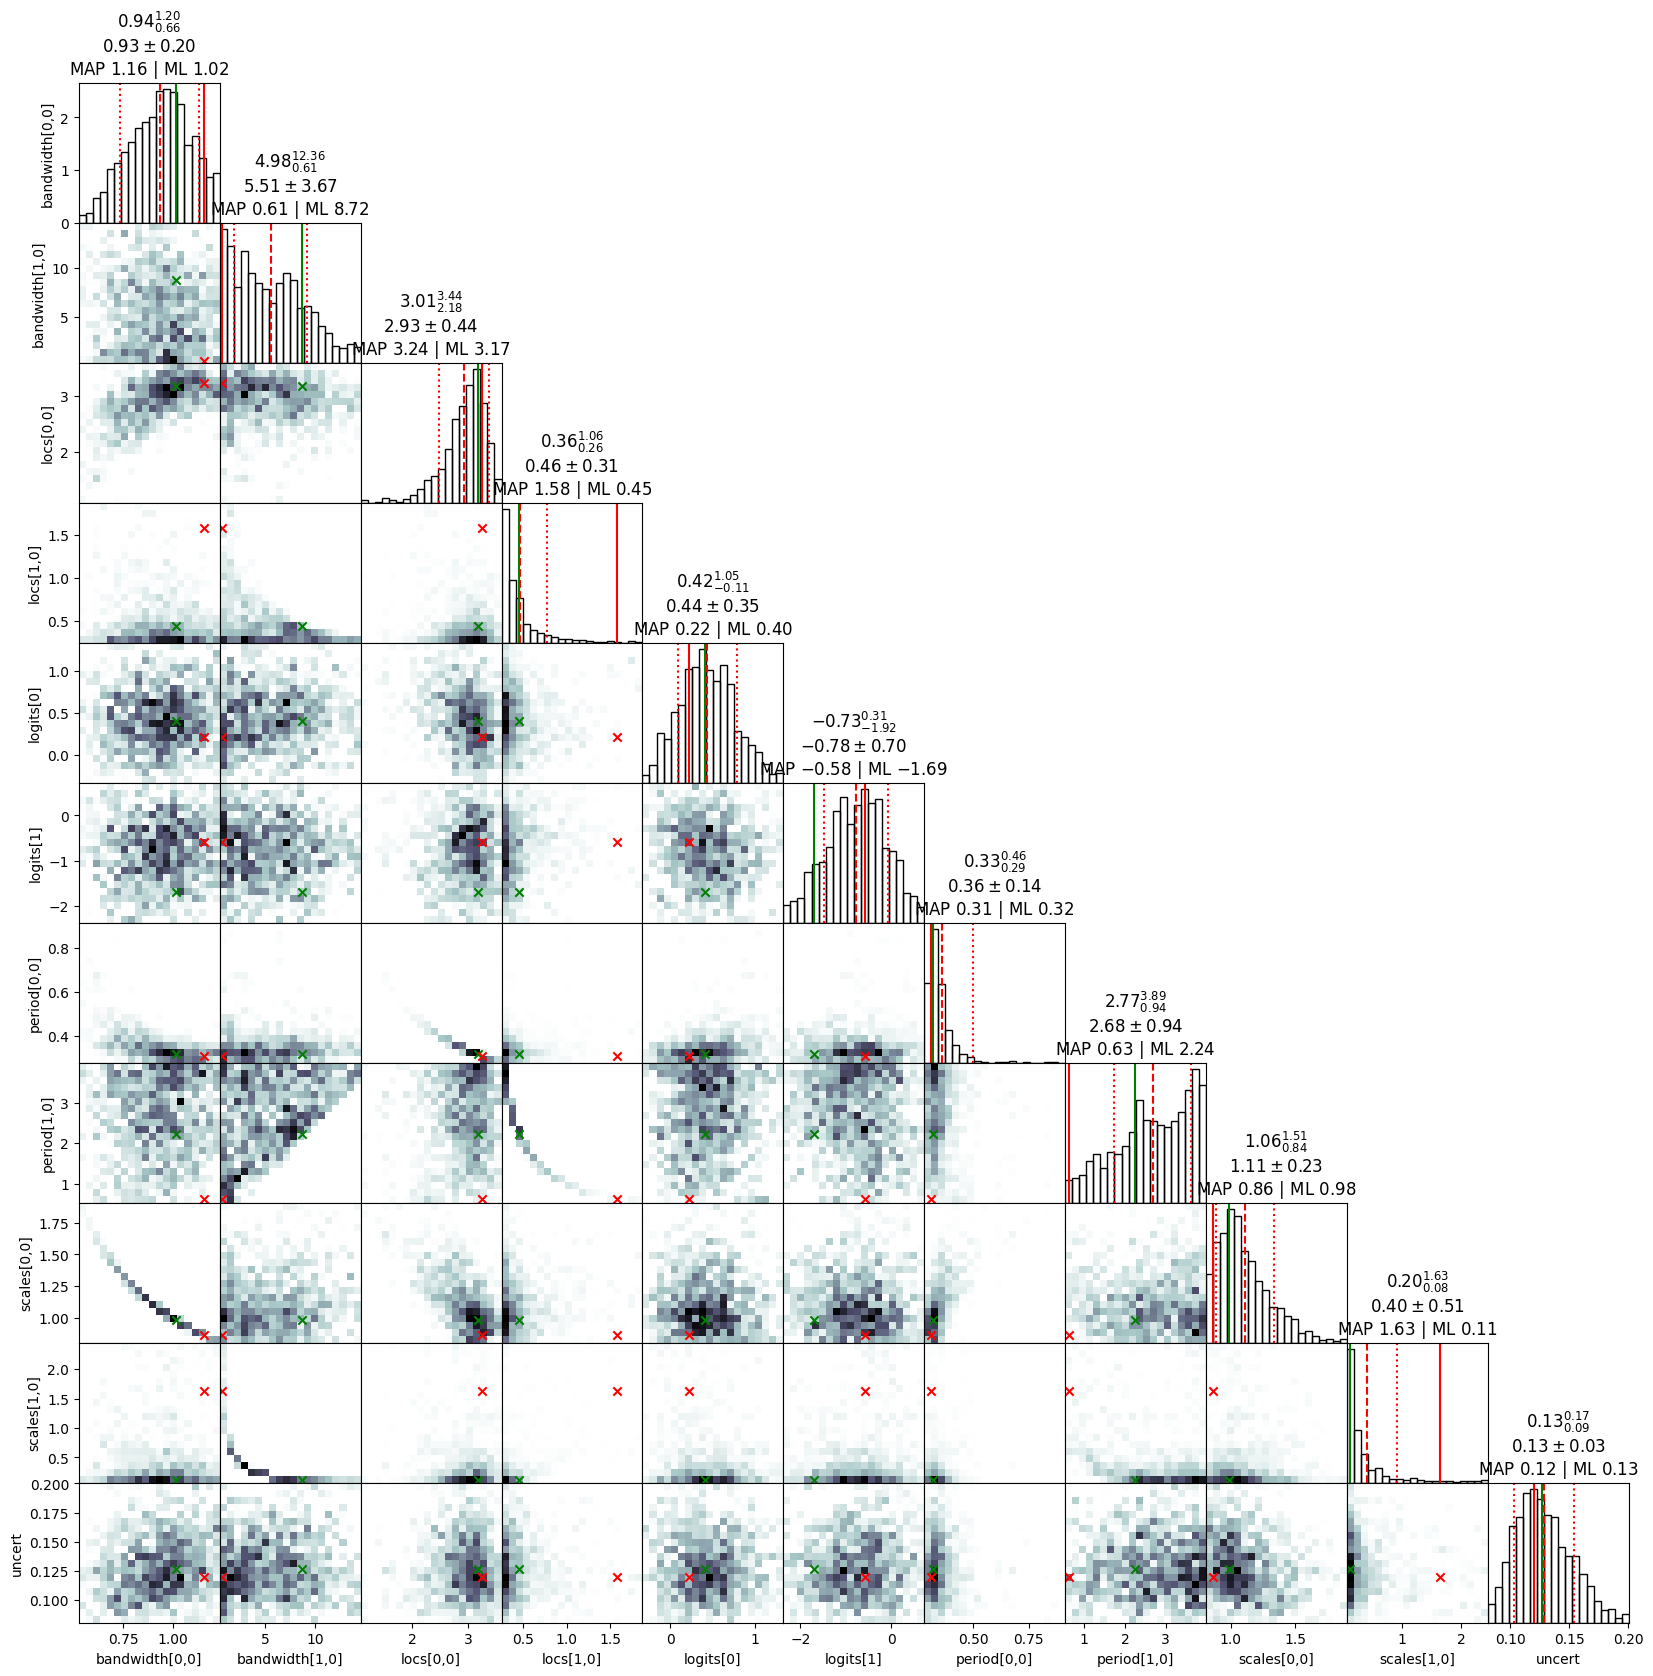

In [3]:


import jax
from jaxns import Prior, Model, NestedSampler, summary, plot_diagnostics, plot_cornerplot

kernel = tfpk.SpectralMixture


def log_normal(x, mean, cov):
    L = jnp.linalg.cholesky(cov)
    # U, S, Vh = jnp.linalg.svd(cov)
    log_det = jnp.sum(jnp.log(jnp.diag(L)))  # jnp.sum(jnp.log(S))#
    dx = x - mean
    dx = solve_triangular(L, dx, lower=True)
    # U S Vh V 1/S Uh
    # pinv = (Vh.T.conj() * jnp.where(S!=0., jnp.reciprocal(S), 0.)) @ U.T.conj()
    maha = dx @ dx  # dx @ pinv @ dx#solve_triangular(L, dx, lower=True)
    log_likelihood = -0.5 * x.size * jnp.log(2. * jnp.pi) - log_det - 0.5 * maha
    return log_likelihood


def run(X, Y_obs):
    smallest_dt = jnp.min(jnp.diff(jnp.sort(X, axis=0), axis=0))  # d
    largest_dt = jnp.max(X, axis=0) - jnp.min(X, axis=0)  # d

    def log_likelihood(uncert, kernel_params):
        """
        P(Y|sigma, half_width) = N[Y, f, K]
        Args:
            uncert: noise
            kernel_params: dict of kernel parameters
            
        Returns:
            log likelihood
        """
        K = tfpk.SpectralMixture(**kernel_params).matrix(X, X)
        data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
        mu = jnp.zeros_like(Y_obs)
        log_prob = log_normal(Y_obs, mu, K + data_cov)
        return log_prob

    # Build the model
    n_components = 2

    def prior_model():
        period = yield ForcedIdentifiability(n=2, low=smallest_dt, high=largest_dt, name='period')  # n, d
        locs = yield Prior(1. / period, name='locs')  # n, d
        max_bandwidth = (4. * period)  # n, d
        min_bandwidth = smallest_dt * 2
        bandwidth = yield Prior(
            tfpd.Uniform(min_bandwidth * jnp.ones_like(max_bandwidth), max_bandwidth * jnp.ones_like(max_bandwidth)),
            name='bandwidth')  # n, d
        scales = yield Prior(1. / bandwidth, name='scales')
        logits = yield Prior(tfpd.Normal(0. * jnp.ones(n_components), 1. * jnp.ones(n_components)), name='logits')  # n
        kernel_params = dict(locs=locs,
                             scales=scales,
                             logits=logits)
        uncert = yield Prior(tfpd.HalfNormal(0.2), name='uncert')
        return uncert, kernel_params

    model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

    # model.sanity_check(random.PRNGKey(0), S=100)

    # Create the nested sampler class. In this case without any tuning.
    ns = NestedSampler(model=model, verbose=True)

    termination_reason, state = ns(random.PRNGKey(42))
    return ns.to_results(termination_reason=termination_reason, state=state, trim=False)


results = jax.jit(run)(X, Y_obs)

summary(results)
plot_diagnostics(results)
plot_cornerplot(results)


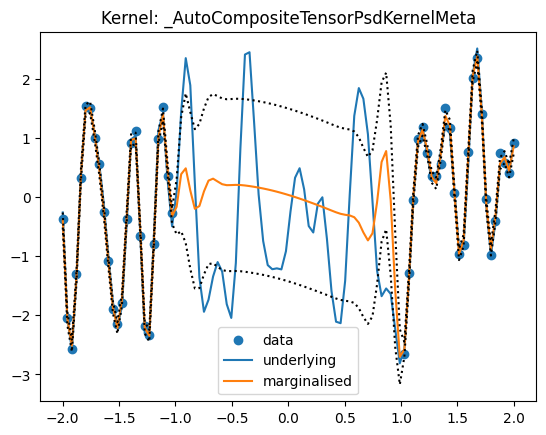

In [4]:
def predict_f_fn(uncert, locs, scales, logits):
    kernel_params = dict(locs=locs,
                         scales=scales,
                         logits=logits)
    Kxx = tfpk.SpectralMixture(**kernel_params).matrix(X, X)
    Ksx = tfpk.SpectralMixture(**kernel_params).matrix(Xstar, X)
    data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
    return Ksx @ jnp.linalg.solve(Kxx + data_cov, Y_obs)


def predict_fvar_fn(uncert, locs, scales, logits):
    kernel_params = dict(locs=locs,
                         scales=scales,
                         logits=logits)
    Kxx = tfpk.SpectralMixture(**kernel_params).matrix(X, X)
    Ksx = tfpk.SpectralMixture(**kernel_params).matrix(Xstar, X)
    Kss = tfpk.SpectralMixture(**kernel_params).matrix(Xstar, Xstar)
    data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
    return jnp.diag(Kss - Ksx @ jnp.linalg.solve(Kxx + data_cov, Ksx.T))


predict_f = marginalise_dynamic(random.PRNGKey(42), results.samples, results.log_dp_mean,
                                results.ESS, predict_f_fn)

predict_fvar = marginalise_dynamic(random.PRNGKey(42), results.samples, results.log_dp_mean,
                                   results.ESS, predict_fvar_fn)

plt.scatter(X[:, 0], Y_obs, label='data')
plt.plot(Xstar[:, 0], Y, label='underlying')
plt.plot(Xstar[:, 0], predict_f, label='marginalised')
plt.plot(Xstar[:, 0], predict_f + jnp.sqrt(predict_fvar), ls='dotted',
         c='black')
plt.plot(Xstar[:, 0], predict_f - jnp.sqrt(predict_fvar), ls='dotted',
         c='black')
plt.title("Kernel: {}".format(kernel.__class__.__name__))
plt.legend()
plt.show()

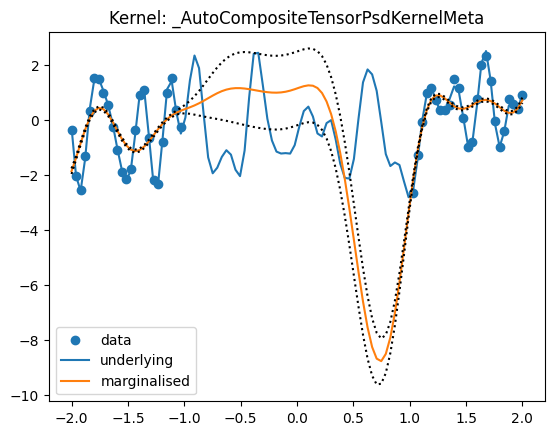

In [5]:
map_sample = maximum_a_posteriori_point(results)

predict_f = evaluate_map_estimate(results, predict_f_fn)

predict_fvar = evaluate_map_estimate(results, predict_fvar_fn)

plt.scatter(X[:, 0], Y_obs, label='data')
plt.plot(Xstar[:, 0], Y, label='underlying')
plt.plot(Xstar[:, 0], predict_f, label='marginalised')
plt.plot(Xstar[:, 0], predict_f + jnp.sqrt(predict_fvar), ls='dotted',
         c='black')
plt.plot(Xstar[:, 0], predict_f - jnp.sqrt(predict_fvar), ls='dotted',
         c='black')
plt.title("Kernel: {}".format(kernel.__class__.__name__))
plt.legend()
plt.show()